## Import Packages

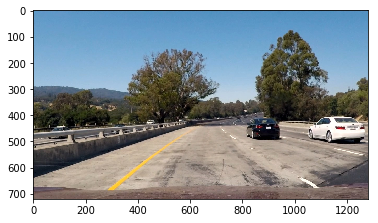

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

plt.imshow(mpimg.imread(os.path.join("test_images","test1.jpg"))) 

## Original Lane Detection Helpers

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def clean_lines(lines, region_of_interest_verticies):
    

    #Remove anything with a slope to close to 0 (horizontal lines)        
    pruned_lines = []
    for line in lines: 
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if (slope > 0.4 or slope < -0.4):
                pruned_lines.append(line)  
                    
    lines = np.array(pruned_lines)    
    
    # Separate by slope into left and right
    left_lines = []
    right_lines = []
    for line in lines: 
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1)) 
            if slope < 0:
                left_lines.append([x1,y1,x2,y2])
            else:
                right_lines.append([x1,y1,x2,y2])
      
    
    #Calc extrapolated left line.  Pull y values from region of interest
    extraoplated_x_left = extrapolate_line(np.average(np.array(left_lines), axis=0),
                                      region_of_interest_verticies[0][1],
                                      region_of_interest_verticies[1][1])

    left_line = [(extraoplated_x_left[0], region_of_interest_verticies[0][1]), 
                       (extraoplated_x_left[1], region_of_interest_verticies[1][1])]
    
    #Calc extrapolated right line.  Pull y values from region of interest
    extraoplated_x_right = extrapolate_line(np.average(np.array(right_lines), axis=0),
                                      region_of_interest_verticies[2][1],
                                      region_of_interest_verticies[3][1])
    
    right_line = [(extraoplated_x_right[0], region_of_interest_verticies[2][1]), 
                       (extraoplated_x_right[1], region_of_interest_verticies[3][1])]
    
    return [left_line,right_line]


def extrapolate_line(line, y_boundary_1, y_boundary_2):
    # Calculate slope
    try:
        slope = ((line[3]-line[1])/(line[2]-line[0])) 
    except IndexError:
        # For some reason, the "Challege" video causes HoughLinesP to produce some "empty" lines...
        return [-1,-1]        
    
    # Calculate x1 and x2 using modified slope forumla x1 = x2 - (y2 -y1)/slope 
    x1 = int(line[0] - (line[1] - y_boundary_1)/slope)
    x2 = int(line[2] - (line[3] - y_boundary_2)/slope)
    
    return [x1,x2]



def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, region_of_interest_verticies):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)    
                
    cleaned_lines = clean_lines(lines, region_of_interest_verticies)
    cv2.line(line_img, cleaned_lines[0][0], cleaned_lines[0][1], [255, 0, 0], 5)
    cv2.line(line_img, cleaned_lines[1][0], cleaned_lines[1][1], [255, 0, 0], 5)
    
    
    cv2.line(line_img,tuple(region_of_interest_verticies[0]),tuple(region_of_interest_verticies[1]), [0,255,0], 7)
    cv2.line(line_img,tuple(region_of_interest_verticies[1]),tuple(region_of_interest_verticies[2]), [0,255,0], 7)
    cv2.line(line_img,tuple(region_of_interest_verticies[2]),tuple(region_of_interest_verticies[3]), [0,255,0], 7)
    cv2.line(line_img,tuple(region_of_interest_verticies[3]),tuple(region_of_interest_verticies[0]), [0,255,0], 7)
    
    return cleaned_lines, line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def lane_finding_pipeline(img, region_mask):
    
    #Use Canny edge detection on graysclaed image
    guassian_kernel_size = 5
    low_threshold = 50
    high_threshold = 150
    edges = canny(gaussian_blur(grayscale(img),guassian_kernel_size),low_threshold,high_threshold)
    
    # Mask area of interest (Use image size to calculate this to account for image/video sizes)
    masked_image = region_of_interest(edges,region_mask)
    
    # Apply Hough transform and draw wighted lines  
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 2
    lines, line_img = hough_lines(masked_image,rho, theta, threshold, min_line_len, max_line_gap,region_mask[0])
    line_img = weighted_img(line_img,img)
    return lines, line_img


## Camera Calibration

In [3]:
class CameraCalibration():
    """A class that contains the calibration data gathered from calibration images

    Attributes:
        chessboardImagesPath (str): The path to the calibration chessboard images
        nx (int): number of cols in chessboard images
        ny (int): number of rows in chessboard images
        perspectiveTransformCalibrationFilePath (str): The path to the calibration image used for perspective transform
    """
    def __init__(self, chessboardImagesPathIn, nxIn, nyIn, perspectiveTransformCalibrationFilePathIn):        
        self.chessboardImagesPath = chessboardImagesPathIn
        self.perspectiveTransformCalibrationFilePath = perspectiveTransformCalibrationFilePathIn
        self.nx = nxIn
        self.ny = nyIn
        self.objpoints = []
        self.imgpoints = [] 
        self.objp = np.zeros((nxIn*nyIn,3), np.float32)
        self.objp[:,:2] = np.mgrid[0:nxIn,0:nyIn].T.reshape(-1,2)
        self.mtx = None
        self.dist = None
        self.M = None
        self.Minv = None
        
        self.process_calibration_data()
    
    def process_calibration_data(self):
        self.calc_distortion()
        self.calc_perspective()
    
    def calc_distortion(self):
        images = glob.glob(os.path.join(self.chessboardImagesPath,"*.jpg"))
        for fname in images:
            img = mpimg.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (self.nx,self.ny), None)
            if ret:
                self.imgpoints.append(corners)
                self.objpoints.append(self.objp)
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, gray.shape[::-1], None, None)
   
    def calc_perspective(self):
        
        img = mpimg.imread(self.perspectiveTransformCalibrationFilePath)
        
        ### Use original line finding to find the lanes on the perspective calibration image 
        imshape = img.shape
        region_mask = np.array([[(50,imshape[0]),
                        (imshape[1]/2 - 100, imshape[0]/2+100), 
                        (imshape[1]/2 + 100, imshape[0]/2+100), 
                        (imshape[1]-50,imshape[0])]], 
                        dtype=np.int32)        
        lines, lane_image = lane_finding_pipeline(img,region_mask)
        
        
        # plt.imshow(lane_image)
        
        src = np.float32([lines[0][0],
                          lines[0][1],
                          lines[1][0],
                          lines[1][1]])
        dst = np.float32([[lines[0][0][0],imshape[0]],
                          [lines[0][0][0],0],
                          [lines[1][1][0],0],
                          [lines[1][1][0],imshape[0]]])
        
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        
        # plt.imshow(self.warp_to_overhead_perspective(img))

    def undistort_image(self, InputImage):
        return cv2.undistort(InputImage, self.mtx, self.dist, None, self.mtx)
        
    def warp_to_overhead_perspective(self, InputImage):
        return cv2.warpPerspective(InputImage, self.M, (InputImage.shape[1],InputImage.shape[0]), flags=cv2.INTER_LINEAR)
        
    def warp_to_original_perspective(self, InputImage):
        return cv2.warpPerspective(InputImage, self.Minv, (InputImage.shape[1],InputImage.shape[0]), flags=cv2.INTER_LINEAR)


In [4]:
cameraCal = CameraCalibration("camera_cal",9,6, os.path.join("test_images","straight_lines2.jpg"))

## Camera Helper Class

In [5]:
class CameraImage():
    """A class that contains the characteristics of each camera image being used for lane detection.

    Attributes:
        imagePath (str): The path to the image itself
    """
    def __init__(self, imageIn, cameraCal):        
        self.img = imageIn
        self.originalImage = imageIn
        self.cal = cameraCal
        self.distorted = True
        self.pipelined = False
        self.transformed = False
                           
                           
    def abs_sobel_thresh(self, img, orient='x', sobel_kernel=3, thresh=(0, 255)):     
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Use inclusive thresholds
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        # Return the result
        return binary_output

    def mag_thresh(self, img, sobel_kernel=3, thresh=(0, 255)):  
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

        # Return the binary image
        return binary_output

    def dir_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):   
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return binary_output
    
    def hls_select(self, chan, thresh=(0, 255)):
        binary_output = np.zeros_like(chan)
        binary_output[(chan > thresh[0]) & (chan <= thresh[1])] = 1
        return binary_output
    
    
    def hls(self):
        return cv2.cvtColor(self.img, cv2.COLOR_RGB2HLS)
    
    def gray(self):
        return cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)                           
    
    def undistort_image(self):
        
        if self.distorted:
            self.img = cameraCal.undistort_image(self.img) 
            self.distorted = False
        
    
    def apply_thresholds(self):                         
               
        if not self.pipelined:            
            #Gradients on Greyscale
            sobelx = self.abs_sobel_thresh(self.gray(), orient='x', thresh=(20, 100)) 
            sobeldir = self.dir_threshold(self.gray(), sobel_kernel=15, thresh=(0.5,1.3)) 
            sobel_combined = np.zeros_like(sobeldir)
            sobel_combined[(sobelx == 1) & (sobeldir == 1) ] = 1
                      
            # Convert to HLS
            hls = self.hls()
            h_channel = hls[:,:,0]
            s_channel = hls[:,:,2]

            # Hue Channel Select
            h_select= self.hls_select(h_channel, thresh=(0, 30))
                    
            # Saturation Select and Magnitude Combined
            s_select = self.hls_select(s_channel, thresh=(170, 255))                          
            
            combined_binary = np.zeros_like(h_select)
            combined_binary[((h_select == 1) & (s_select == 1)) | (sobel_combined == 1)] = 1          

            self.img = combined_binary
            self.pipelined = True
    
    def perspective_transform(self): 
        
        if not self.transformed:
            self.img = cameraCal.warp_to_overhead_perspective(self.img)
            self.transformed = True
        

    def apply_full_pipeline(self): 
        self.undistort_image()
        self.apply_thresholds()
        self.perspective_transform()
        

## Test On Image

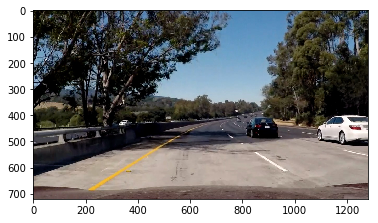

In [6]:
image1 = CameraImage(mpimg.imread(os.path.join("test_images","test5.jpg")), cameraCal)
plt.imshow(image1.img) 

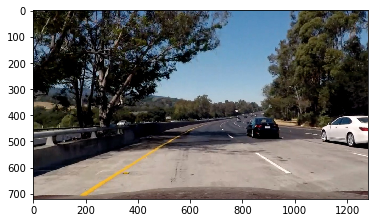

In [7]:
image1.undistort_image()
plt.imshow(image1.img) 
mpimg.imsave(os.path.join("output_images","test5_undistorted.jpg"),image1.img)

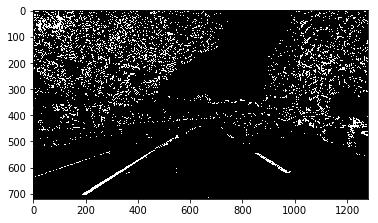

In [8]:
image1.apply_thresholds()
plt.imshow(image1.img,cmap='gray') 
mpimg.imsave(os.path.join("output_images","test5_gradient_thresholds.jpg"),image1.img,cmap='gray')

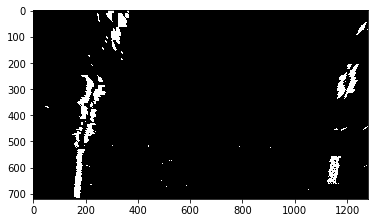

In [9]:
image1.perspective_transform()
plt.imshow(image1.img,cmap='gray') 
mpimg.imsave(os.path.join("output_images","test5_perspective_warp.jpg"),image1.img,cmap='gray')

### Lane Finding Helpers

In [10]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100,  minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    marked_lane_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint      

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(marked_lane_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(marked_lane_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, marked_lane_img


def search_around_poly(binary_warped, left_fit, right_fit, left_fitx, right_fitx, margin=100):      
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Set the area of search based on activated x-values 
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    marked_lane_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(marked_lane_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(marked_lane_img, np.int_([right_line_pts]), (0,255, 0))

    return leftx, lefty, rightx, righty, marked_lane_img 

In [11]:
def fit_polynomial(binary_warped, leftx, lefty, rightx, righty, marked_lane_img, plot_lanes=False):    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Colors in the left and right lane regions
    marked_lane_img[lefty, leftx] = [255, 0, 0]
    marked_lane_img[righty, rightx] = [0, 0, 255]

    if plot_lanes:
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return left_fitx, right_fitx, ploty, left_fit, right_fit, marked_lane_img

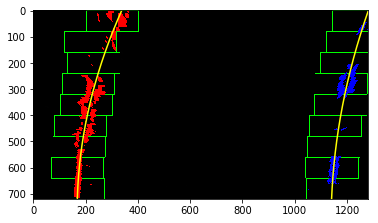

In [12]:
leftx, lefty, rightx, righty, marked_lane_img = find_lane_pixels(image1.img)
left_fitx, right_fitx, ploty, left_fit, right_fit, marked_lane_img = fit_polynomial(image1.img, leftx, lefty, rightx, righty, marked_lane_img, plot_lanes=True )
plt.imshow(marked_lane_img)
mpimg.imsave(os.path.join("output_images","test5_found_lanes.jpg"),marked_lane_img)

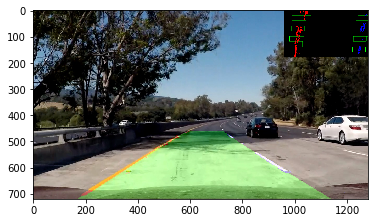

In [13]:
def combine_images(warped_image, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, original_image, marked_lane_img, cameraCal):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    marked_lane_img_small = np.zeros((int(marked_lane_img.shape[0]/4),int(marked_lane_img.shape[1]/4),marked_lane_img.shape[2]))
    marked_lane_img_small = cv2.resize(marked_lane_img, (int(marked_lane_img.shape[1]/4),int(marked_lane_img.shape[0]/4)))
    
    # Add lane points
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cameraCal.warp_to_original_perspective(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    # Add composite of marked lane image
    result[:marked_lane_img_small.shape[0],-marked_lane_img_small.shape[1]:,:] = marked_lane_img_small
    return result


result = combine_images(image1.img, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, image1.originalImage, marked_lane_img, cameraCal)

plt.imshow(result)
mpimg.imsave(os.path.join("output_images","test5_final_result.jpg"),result)

In [14]:
y_eval = np.max(ploty)
left_curverad =    ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad =   ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

print("Left Curve Radius in Pixels: {0}".format(left_curverad))
print("Right Curve Radius in Pixels: {0}".format(right_curverad))

avg_calc_radius_pixels = (left_curverad+right_curverad)/2

print("Average Curve Radius in Pixels: {0}".format(avg_calc_radius_pixels))

lane_size = right_fitx[0] - left_fitx[-1]
lane_center = lane_size/2 + left_fitx[-1]
dist_from_center_pixels = np.absolute(image1.originalImage.shape[1]/2 - lane_center)
print("Distance from lane center in Pixels: {0}".format(dist_from_center_pixels))

Left Curve Radius in Pixels: 1727.9998178742378
Right Curve Radius in Pixels: 2342.0371932393327
Average Curve Radius in Pixels: 2035.0185055567854
Distance from lane center in Pixels: 84.98624788916516


## Combined Pipeline

In [18]:
ym_per_pix = 38.5 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
left_fit_g = None
right_fit_g = None
left_fitx_g = None
right_fitx_g = None
first_frame_g = True

def reset_fit():
    global first_frame_g
    first_frame_g = True

def process_image(image):
    
    #Init Cam Image
    camImage = CameraImage(image, cameraCal)
    
    # Apply pipline
    camImage.apply_full_pipeline()
    
    #Global fits
    global left_fit_g
    global right_fit_g
    global left_fitx_g
    global right_fitx_g
    global first_frame_g
    
    # Find Lanes
    if first_frame_g:
        leftx, lefty, rightx, righty, marked_lane_img = find_lane_pixels(camImage.img)
        first_frame_g = False
    else:
        leftx, lefty, rightx, righty, marked_lane_img = search_around_poly(camImage.img, left_fit_g, 
                                                                           right_fit_g, left_fitx_g, right_fitx_g,)
    
    
    left_fitx_g, right_fitx_g, ploty, left_fit_g, right_fit_g, marked_lane_img = fit_polynomial(camImage.img, leftx, lefty, rightx, righty, marked_lane_img)
    
    # Combine    
    result = combine_images(camImage.img, leftx, lefty, rightx, righty, left_fitx_g, right_fitx_g, ploty, camImage.originalImage, marked_lane_img, cameraCal)

    # Calc distance from center 
    lane_size = right_fitx_g[-1] - left_fitx_g[0]
    lane_center = lane_size/2 + left_fitx_g[0]
    dist_from_center_pixels = np.absolute(image1.originalImage.shape[1]/2 - lane_center)
           
    dist_from_center_meters = dist_from_center_pixels * xm_per_pix        
        
    #Calc Curve radius in Meters:  
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    left_radius_meters = ((1 + (2*left_fit_m[0]*y_eval*ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_radius_meters = ((1 + (2*right_fit_m[0]*y_eval*ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])

    cv2.putText(result,"Left radius: %6.4fm" % left_radius_meters, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
    cv2.putText(result,"Right radius: %6.4fm" % right_radius_meters, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
    cv2.putText(result,"Dist from Center: %3.4fm" % dist_from_center_meters, (10,150), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
    return result


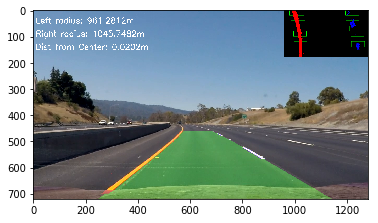

In [19]:
clip = VideoFileClip("project_video.mp4")
plt.imshow(process_image(clip.get_frame(4)))
clip.reader.close()
clip.audio.reader.close_proc()

## Test on Videos

In [ ]:
reset_fit()
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



  5%|████▎                                                                           | 67/1261 [00:15<04:43,  4.21it/s]


 10%|████████▏                                                                      | 131/1261 [00:31<04:31,  4.16it/s]

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Line Helper Class

In [40]:
class LaneLine():
    """A class that contains the characteristics of each line detection.

    Attributes:
        detected (bool): Was the line detected in the last iteration?
        size_of_history (int): amount of historical fits to store
        recent_xfitted (queue): x values of the last "size_of_history" fits of the line
        recent_fitted (queue): polynomial coefficient of the last "size_of_history" fits of the line
        bestx (int): average x values of the fitted line over the last "size_of_history" iterations
        best_fit (int): polynomial coefficients averaged over the last "size_of_history" iterations
        current_fit (int): polynomial coefficients for the most recent fit
        current_fitx (int): x values for the most recent fit
        radius_of_curvature (int): radius of curvature of the line in some units
        line_base_pos (int): distance in meters of vehicle center from the line
        diffs (array): difference in fit coefficients between last and new fits
        allx (array): x values for detected line pixels
        ally (array): y values for detected line pixels
    """
    def __init__(self):        
        self.detected = False 
        self.size_of_history = 5
        self.recent_xfitted = Queue(maxsize=self.size_of_history)
        self.recent_fitted = Queue(maxsize=self.size_of_history)
        self.bestx = None       
        self.best_fit = None
        self.current_fit = [np.array([False])] 
        self.current_fitx = None
        self.radius_of_curvature = None 
        self.line_base_pos = None 
        self.diffs = np.array([0,0,0], dtype='float') 
        self.allx = None  
        self.ally = None         
        
        
    def add_new_lines(x,y,image_height, image_width):
        self.allx = x
        self.ally = y
        
        # Fit a second order polynomial to each using `np.polyfit`
        self.current_fit = np.polyfit(y, x, 2)

        #Calc fit difference
        if self.detected:
            self.diffs = self.best_fit - self.current_fit
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, image_height-1, image_height )
        try:
            self.current_fitx = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]
        except TypeError:
            print('The function failed to fit a line!')
            self.current_fitx = 1*ploty**2 + 1*ploty
            self.detected = False
        
        # Calculate fit in Meters
        fit_m = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)  
        
        # Calc radius in meters
        self.radius_of_curvature = ((1 + (2*fit_m[0]*image_height*ym_per_pix + fit_m[1])**2)**1.5) / np.absolute(2*fit_m[0])
        
        # Calc lane distatnce from center
        self.line_base_pos = np.absolute(image_width/2 - self.current_fitx[0]) * xm_per_pix
        
        self.update_best_fit()
        
    
    def update_best_fit():        
        if self.detected:
            ## Validate vals                    
            print(self.diffs)
            print(self.radius_of_curvature)
            print(self.line_base_pos)

        
        if self.recent_xfitted.full():
            self.recent_xfitted.get()
            self.recent_fitted.get()
            self.detected = True
        
            self.recent_xfitted.put(self.current_fitx)        
            self.recent_fitted.put(self.current_fit) 

            self.bestx = np.average(array(self.recent_xfitted))
            self.best_fit = np.average(array(self.recent_fitted))
        
    